Load the forecasts

In [4]:
import pandas as pd

df_forecasts = pd.read_csv("/Users/fohlen/Downloads/export_2024-11-08/merged.csv")
df_forecasts["recorded_at"] = pd.to_datetime(df_forecasts["recorded_at"], utc=True)
df_forecasts["recorded_at"] = df_forecasts["recorded_at"].dt.floor('H')
df_forecasts["forecast_time"] = pd.to_datetime(df_forecasts["forecast_time"], utc=True)
df_forecasts.head()

/var/folders/k6/hdzmrkf915d0twbr_qmhy9l00000gn/T/ipykernel_27133/3023989251.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_forecasts["recorded_at"] = df_forecasts["recorded_at"].dt.floor('H')


,recorded_at,station_id,forecast_time,parameter,value
0,2024-05-12 15:00:00+00:00,10513,2024-05-12 15:00:00+00:00,precipitation_height_significant_weather_last_1h,0.0
1,2024-05-12 15:00:00+00:00,10513,2024-05-12 16:00:00+00:00,precipitation_height_significant_weather_last_1h,0.0
2,2024-05-12 15:00:00+00:00,10513,2024-05-12 17:00:00+00:00,precipitation_height_significant_weather_last_1h,0.0
3,2024-05-12 15:00:00+00:00,10513,2024-05-12 18:00:00+00:00,precipitation_height_significant_weather_last_1h,0.0
4,2024-05-12 15:00:00+00:00,10513,2024-05-12 19:00:00+00:00,precipitation_height_significant_weather_last_1h,0.0


Load the actual weather

In [2]:
df_measure = pd.read_csv("data/historical_weather.csv")
df_measure["recorded_at"] = pd.to_datetime(df_measure["recorded_at"], utc=True)
df_measure.head()

,recorded_at,station_id,parameter,value
0,2024-05-06 00:00:00+00:00,433,precipitation_height,0.0
1,2024-05-06 01:00:00+00:00,433,precipitation_height,0.0
2,2024-05-06 02:00:00+00:00,433,precipitation_height,0.0
3,2024-05-06 03:00:00+00:00,433,precipitation_height,0.0
4,2024-05-06 04:00:00+00:00,433,precipitation_height,0.0


Mapping from forecast to measurement

In [3]:
reverse_station_mapping = {
    433: 10384, 2667: 10513, 3379: 10865, 1443: 10803, 
    5906: 10729, 2522: 10727, 4104: 10776, 1270: 10554, 
    5419: 10555
}

reverse_parameter_mapping = {
    'precipitation_height': 'precipitation_height_significant_weather_last_1h',
    'temperature_air_mean_2m': 'temperature_air_mean_200'
}

In [85]:
from tqdm import tqdm

regression_rows = []

rows = df_measure[
  (df_measure["recorded_at"].dt.dayofyear == 200) &
  (df_measure["parameter"] == "temperature_air_mean_2m")
]

measure_times = rows.recorded_at.unique().tolist()

for measure_time in tqdm(measure_times):
    parameter = "temperature_air_mean_2m"

    forecast_rows_measure_time = df_forecasts[
        (df_forecasts["forecast_time"] == measurement_time) &
        (df_forecasts["parameter"] == reverse_parameter_mapping[parameter])
    ]

    for n in range(1, 241):
        filter_time = measurement_time - pd.Timedelta(hours=n)

        forecast_rows = forecast_rows_measure_time[
         (forecast_rows_measure_time["recorded_at"] == filter_time)
        ]
        value = forecast_rows.value.mean()
        
        regression_rows.append((value, n, measurement_time, parameter))

regression_df = pd.DataFrame(regression_rows, columns=["value", "n", "measure_time", "parameter"])
print(regression_df.head())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:22<00:00,  1.06it/s]

    value  n              measure_time                parameter
0  292.14  1 2024-07-18 23:00:00+00:00  temperature_air_mean_2m
1  291.93  2 2024-07-18 23:00:00+00:00  temperature_air_mean_2m
2  291.87  3 2024-07-18 23:00:00+00:00  temperature_air_mean_2m
3  291.90  4 2024-07-18 23:00:00+00:00  temperature_air_mean_2m
4  291.93  5 2024-07-18 23:00:00+00:00  temperature_air_mean_2m


In [106]:
X = regression_df.value.fillna(0).to_numpy().reshape((240, 24))
y = rows.groupby(rows.recorded_at.dt.hour).value.mean()

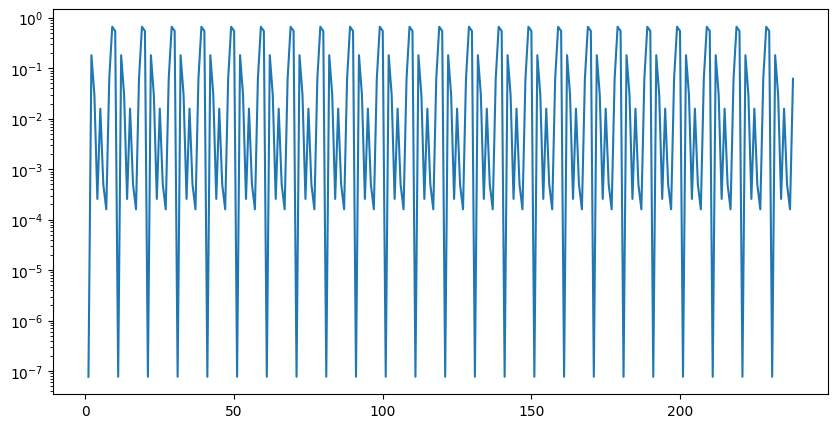

In [116]:
import matplotlib.pyplot as plt
from scipy import stats

xs = list(range(1, 239))
ys = []

for n in xs:
    result = stats.linregress(X[n, :], y)
    ys.append(result.rvalue)

fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(xs, ys)
plt.yscale("log")

plt.show()